In [7]:
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split

import time

from auxfunctions import *
from implementations import *

import warnings
warnings.filterwarnings('ignore')

## Figure 5 (b) paper, versión multivariada $p=2$

In [3]:
d = 1
n = 30
sup = 1

nu_1 = 1/2
nu_2 = 1/2
theta_1 = 5
theta_2 = 10

nu_12 = ( nu_1 + nu_2 ) / 2
theta_12 = min(theta_1, theta_2)
rho_12 = (theta_12**2/(theta_1*theta_2))**(d/2) * ( gamma(nu_1+d/2)*gamma(nu_2+d/2) / (gamma(nu_1)*gamma(nu_2)) )**(1/2) * gamma(nu_12)/gamma(nu_12+d/2)
rho_12

0.7071067811865476

In [4]:
X = gen_observation_points(d, n, sup)
X, X, Y_1, Y_2 = gen_observations(X, X, 
                                  matern_model(theta_1, nu_1), 
                                  matern_model(theta_2, nu_2),
                                  matern_model(theta_12, nu_12),
                                  rho_12)

In [5]:
X_test = np.linspace(0,1,101).reshape(101,1)
# X_test = gen_observation_points(d, 100, sup)

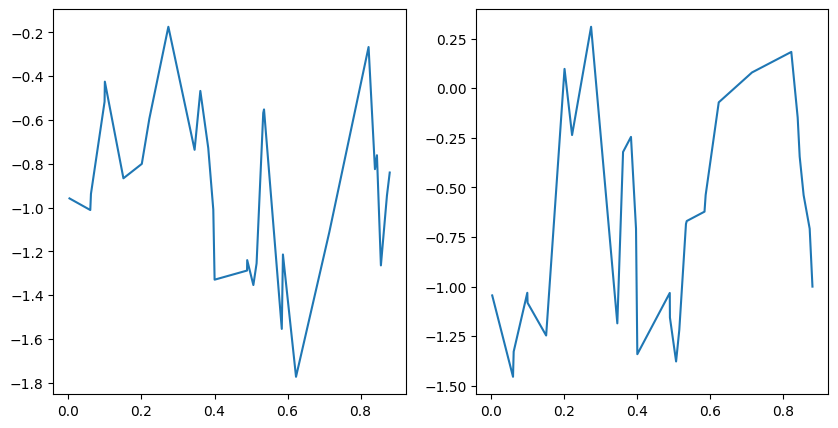

In [6]:
fig, axs = plt.subplots(1,2,figsize=(10,5))

sort_ind = np.argsort(X, axis=0).flatten()
axs[0].plot(X[sort_ind], Y_1[sort_ind])
axs[1].plot(X[sort_ind], Y_2[sort_ind]);

In [7]:
Ns = [2, 5]
As = [
    np.argsort(X, axis=0).reshape(15,2).tolist(),
    np.random.choice(np.arange(n), size=(n//2, 2), replace=False).tolist(),
    # np.random.choice(np.arange(n), size=(n//2, 2), replace=False).tolist()
      ]
rmses_NcoK = []
rmses_coKNN = []

num_iterations = 100

for _ in range(num_iterations):
    rmse_coKNN = np.zeros(len(Ns))
    rmse_NcoK = np.zeros(len(As))

    X = gen_observation_points(d, n, sup)
    X, X, Y_1, Y_2 = gen_observations(X,X,matern_model(theta_1,nu_1),matern_model(theta_2,nu_2),matern_model(theta_12,nu_12),rho_12)
    
# CO KRIGING
    sigma = K(X, X, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), 
              matern_model(theta_12, nu_12), rho_12)
    Y_coK = co_kriging(X_test, X, X, Y_1, Y_2, matern_model(theta_1, nu_1),
                matern_model(theta_12, nu_12), rho_12, sigma)

# CO KRIGING NN
    for i, N in enumerate(Ns):    
        coKNN = coKrigingNN(X, X, Y_1, Y_2, N, matern_model, theta_1, theta_2, 
                            theta_12, nu_1, nu_2, nu_12, rho_12)
        Y_pred = coKNN.predict(X_test)
        rmse_coKNN[i] += root_mean_squared_error(Y_coK, Y_pred)

# NESTED CO KRIGING
    for i, A in enumerate(As):
        NcoK = NestedCoKriging(X, X, Y_1, Y_2, matern_model, 
                                theta_1, theta_2, theta_12, nu_1,
                                nu_2, nu_12, rho_12)
        Y_pred = NcoK.predict(X_test, A, A)
        rmse_NcoK[i] += root_mean_squared_error(Y_coK, Y_pred)
    
    rmses_coKNN.append(rmse_coKNN)
    rmses_NcoK.append(rmse_NcoK)


rmses_coKNN = np.array(rmses_coKNN)
rmses_NcoK = np.array(rmses_NcoK)

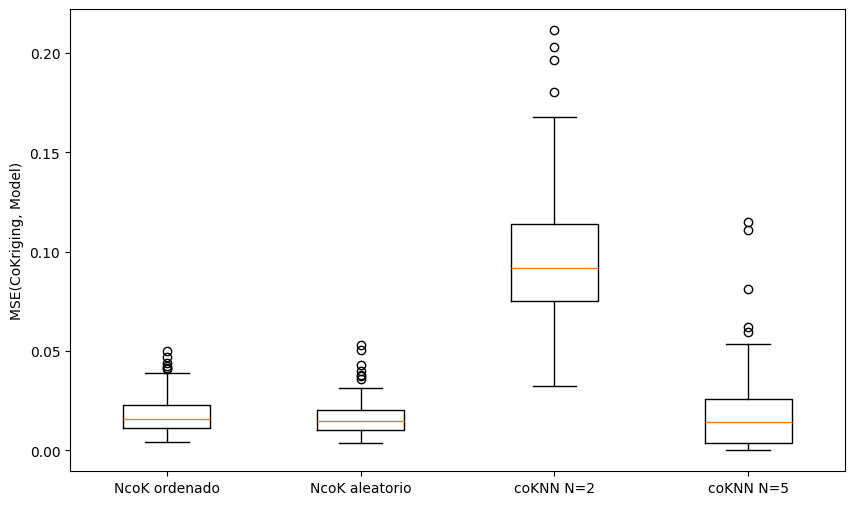

In [8]:
plt.figure(figsize=(10,6))

plt.boxplot(np.hstack([rmses_NcoK, rmses_coKNN]))

plt.xticks(range(1, 3 + len(Ns)), ['NcoK ordenado', 'NcoK aleatorio'] + [f'coKNN {N=}' for N in Ns])
plt.ylabel('MSE(CoKriging, Model)')
plt.show()

# $d = 2$

In [18]:
d = 2
n = 10_000
sup = 1

nu_1 = 1/2
nu_2 = 1/2
theta_1 = 4
theta_2 = 5

nu_12 = ( nu_1 + nu_2 ) / 2
theta_12 = min(theta_1, theta_2)
rho_12 = (theta_12**2/(theta_1*theta_2))**(d/2) * ( gamma(nu_1+d/2)*gamma(nu_2+d/2) / (gamma(nu_1)*gamma(nu_2)) )**(1/2) * gamma(nu_12)/gamma(nu_12+d/2)
rho_12

0.8

In [19]:
X = gen_observation_points(d, n, sup)
X, X, Y_1, Y_2 = gen_observations(X, X, 
                                  matern_model(theta_1, nu_1), 
                                  matern_model(theta_2, nu_2),
                                  matern_model(theta_12, nu_12),
                                  rho_12)

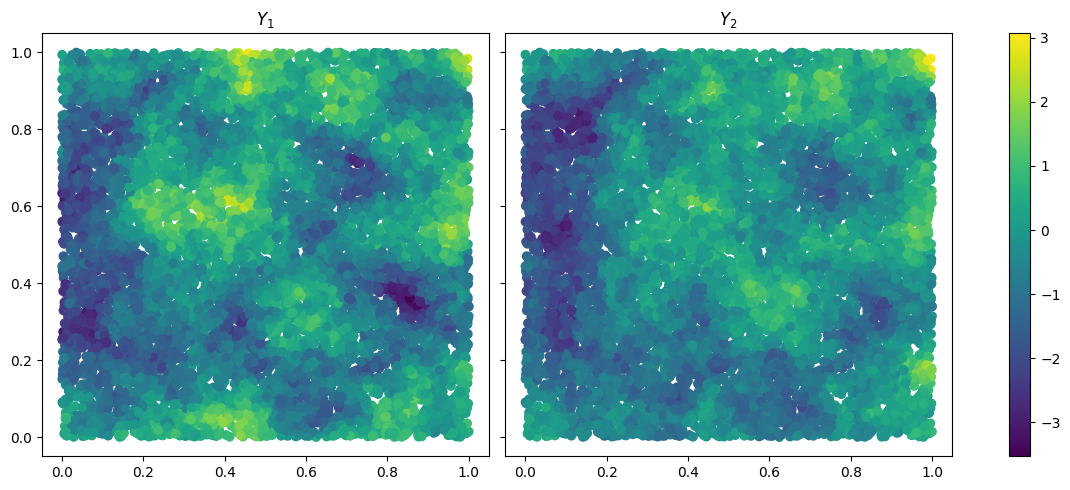

In [20]:
NestedCoKriging(X, X, Y_1, Y_2, cauchy_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12).plot_obs()

In [21]:
X_test = gen_observation_points(d, 100, sup)

In [25]:
n * 0.1 // 100

10.0

In [28]:
Ns = [1, 10, 100]
As = [
    gen_A(X, 500),  # 20
    gen_A(X, 200),  # 50
    gen_A(X, 100),  # 100
    ]
rmses_NcoK = []
rmses_coKNN = []

num_replications = 50

for _ in range(num_replications):
    rmse_coKNN = np.zeros(len(Ns))
    rmse_NcoK = np.zeros(len(As))

    X = gen_observation_points(d, n, sup)
# CO KRIGING
    sigma = K(X, X, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), 
              matern_model(theta_12, nu_12), rho_12)
    
    Y = np.linalg.cholesky(sigma) @ np.random.normal(0, 1, (n+n))
    Y_1, Y_2 = Y[:n], Y[n:]

    Y_coK = co_kriging(X_test, X, X, Y_1, Y_2, matern_model(theta_1, nu_1),
                matern_model(theta_12, nu_12), rho_12, sigma)

# CO KRIGING NN
    for i, N in enumerate(Ns):    
        coKNN = coKrigingNN(X, X, Y_1, Y_2, N, matern_model, theta_1, theta_2, 
                            theta_12, nu_1, nu_2, nu_12, rho_12)
        Y_pred = coKNN.predict(X_test)
        rmse_coKNN[i] += root_mean_squared_error(Y_coK, Y_pred)

# NESTED CO KRIGING
    for i, A in enumerate(As):
        NcoK = NestedCoKriging(X, X, Y_1, Y_2, matern_model, 
                                theta_1, theta_2, theta_12, nu_1,
                                nu_2, nu_12, rho_12)
        Y_pred = NcoK.predict(X_test, A, A)
        rmse_NcoK[i] += root_mean_squared_error(Y_coK, Y_pred)
    
    rmses_coKNN.append(rmse_coKNN)
    rmses_NcoK.append(rmse_NcoK)

rmses_coKNN = np.array(rmses_coKNN)
rmses_NcoK = np.array(rmses_NcoK)

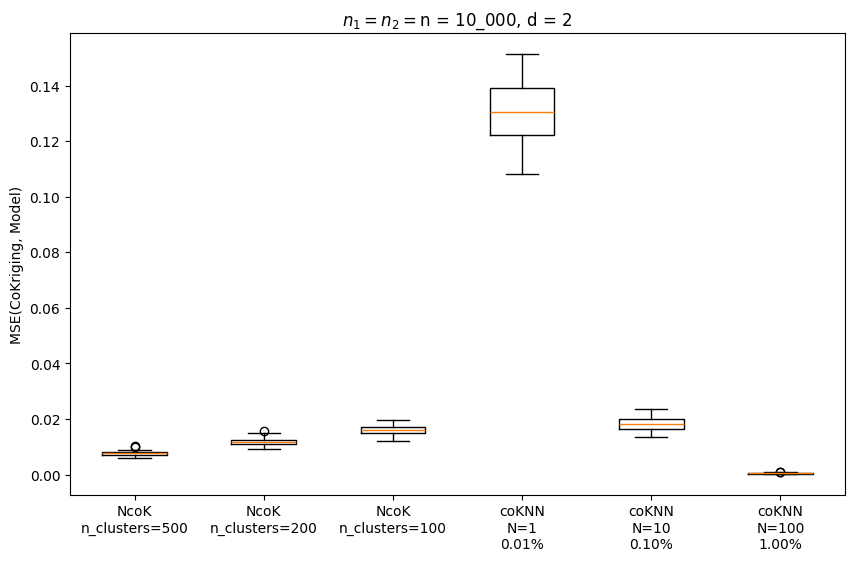

In [38]:
plt.figure(figsize=(10,6))

plt.boxplot(np.hstack([rmses_NcoK, rmses_coKNN]))

plt.xticks(range(1, 1 + len(As) + len(Ns)), [f'NcoK\n{n_clusters=}' for n_clusters in [500, 200, 100]] + [f'coKNN\n{N=}\n{N/n:.2%}' for N in Ns])
plt.ylabel('MSE(CoKriging, Model)')
plt.title(f'$n_1 = n_2 = ${n = :_.0f}, {d = }');

# $d=3$

In [2]:
d = 3
n = 10_000
sup = 1

nu_1 = 1/2
nu_2 = 1/2
theta_1 = 4
theta_2 = 5

nu_12 = ( nu_1 + nu_2 ) / 2
theta_12 = min(theta_1, theta_2)
rho_12 = (theta_12**2/(theta_1*theta_2))**(d/2) * ( gamma(nu_1+d/2)*gamma(nu_2+d/2) / (gamma(nu_1)*gamma(nu_2)) )**(1/2) * gamma(nu_12)/gamma(nu_12+d/2)
rho_12

0.7155417527999329

In [3]:
X_test = gen_observation_points(d, 100, sup)

In [4]:
n * 0.1 // 100

10.0

In [5]:
Ns = [1, 10, 100]

ns_clusters = [
    1_000, # 10
    500,   # 20
    200,   # 50
    100    # 100
]

rmses_NcoK = []
rmses_coKNN = []

num_replications = 50

for _ in range(num_replications):
    rmse_coKNN = np.zeros(len(Ns))
    rmse_NcoK = np.zeros(len(ns_clusters))

    X = gen_observation_points(d, n, sup)
# CO KRIGING
    sigma = K(X, X, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), 
              matern_model(theta_12, nu_12), rho_12)
    
    Y = np.linalg.cholesky(sigma) @ np.random.normal(0, 1, (n+n))
    Y_1, Y_2 = Y[:n], Y[n:]

    Y_coK = co_kriging(X_test, X, X, Y_1, Y_2, matern_model(theta_1, nu_1),
                matern_model(theta_12, nu_12), rho_12, sigma)
    
# CO KRIGING NN
    for i, N in enumerate(Ns):    
        coKNN = coKrigingNN(X, X, Y_1, Y_2, N, matern_model, theta_1, theta_2, 
                            theta_12, nu_1, nu_2, nu_12, rho_12)
        Y_pred = coKNN.predict(X_test)
        rmse_coKNN[i] += root_mean_squared_error(Y_coK, Y_pred)

# NESTED CO KRIGING
    for i, n_clusters in enumerate(ns_clusters):
        A = gen_A(X, n_clusters)
        NcoK = NestedCoKriging(X, X, Y_1, Y_2, matern_model, 
                                theta_1, theta_2, theta_12, nu_1,
                                nu_2, nu_12, rho_12)
        Y_pred = NcoK.predict(X_test, A, A)
        rmse_NcoK[i] += root_mean_squared_error(Y_coK, Y_pred)
    
    rmses_coKNN.append(rmse_coKNN)
    rmses_NcoK.append(rmse_NcoK)
    print(_)

rmses_coKNN = np.array(rmses_coKNN) 
rmses_NcoK = np.array(rmses_NcoK)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


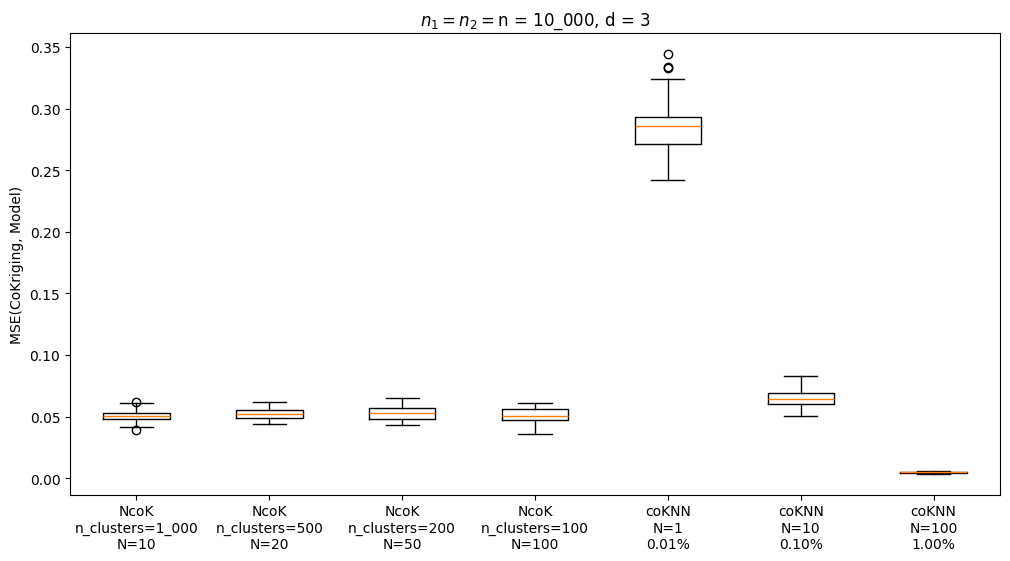

In [6]:
plt.figure(figsize=(12,6))

plt.boxplot(np.hstack([rmses_NcoK, rmses_coKNN]))

plt.xticks(range(1, 1 + len(ns_clusters) + len(Ns)), [f'NcoK\n{n_clusters=:_.0f}\nN={n//n_clusters}' for n_clusters in ns_clusters] + [f'coKNN\n{N=}\n{N/n:.2%}' for N in Ns])
plt.ylabel('MSE(CoKriging, Model)')
plt.title(f'$n_1 = n_2 = ${n = :_.0f}, {d = }');

# NcoK NN

In [8]:
d = 2
n_1 = 1_000 + 100
n_2 = 1_000
sup = 1

nu_1 = 1/2
nu_2 = 1/2
theta_1 = 4
theta_2 = 3

nu_12 = ( nu_1 + nu_2 ) / 2
theta_12 = min(theta_1, theta_2)
rho_12 = -(theta_12**2/(theta_1*theta_2))**(d/2) * ( gamma(nu_1+d/2)*gamma(nu_2+d/2) / (gamma(nu_1)*gamma(nu_2)) )**(1/2) * gamma(nu_12)/gamma(nu_12+d/2)
rho_12

-0.7500000000000001

In [9]:
X_1 = gen_observation_points(d, n_1, sup)
X_2 = gen_observation_points(d, n_2, sup)

In [10]:
sigma = K(X_1, X_2, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), 
            matern_model(theta_12, nu_12), rho_12)

Y = np.linalg.cholesky(sigma) @ np.random.normal(0, 1, (n_1+n_2))
Y_1, Y_2 = Y[:n_1], Y[n_1:]

In [11]:
n_test = 100

X_test, Y_test = X_1[:n_test], Y_1[:n_test]
X_1, Y_1 = X_1[n_test:], Y_1[n_test:]

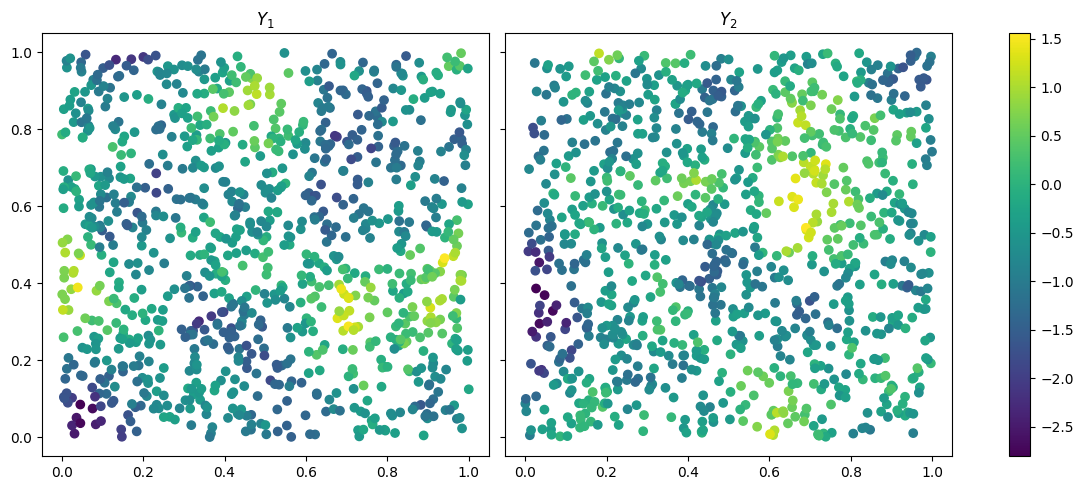

In [12]:
NestedCoKriging(X_1, X_2, Y_1, Y_2, matern_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12).plot_obs()

In [13]:
n_clusters = 100

In [14]:
sigma = sigma[n_test:, :][:, n_test:]

Y_coK = co_kriging(X_test, X_1, X_2, Y_1, Y_2, matern_model(theta_1, nu_1),
                matern_model(theta_12, nu_12), rho_12, sigma)

In [15]:
NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, matern_model, 
                        theta_1, theta_2, theta_12, nu_1,
                        nu_2, nu_12, rho_12)
Y_pred = NcoK.predict(X_test, NN=True, n_clusters=n_clusters)
root_mean_squared_error(Y_pred, Y_test), root_mean_squared_error(Y_pred, Y_coK)

(0.25069793647308375, 0.027076363679461018)

In [16]:
A_1 = gen_A(X_1, n_clusters)
A_2 = gen_A(X_2, n_clusters)

NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, matern_model, 
                        theta_1, theta_2, theta_12, nu_1,
                        nu_2, nu_12, rho_12)
Y_pred = NcoK.predict(X_test, A_1, A_2)
root_mean_squared_error(Y_pred, Y_test), root_mean_squared_error(Y_pred, Y_coK)

(0.2582400464361877, 0.06151111823028327)

In [17]:
n_test = 100

In [ ]:
Ns = [1, 10, 100]
ns_clusters = [
    500, # 2
    100, # 10
    10,  # 100
]
rmses_NcoK = []
rmses_coKNN = []
rmses_NcoK_test = []
rmses_coKNN_test = []

times_NcoK = []
times_coKNN = []

num_replications = 50

for _ in range(num_replications):
    rmse_coKNN = np.zeros(len(Ns))
    rmse_NcoK = np.zeros(2*len(ns_clusters))
    rmse_coKNN_test = np.zeros(len(Ns))
    rmse_NcoK_test = np.zeros(2*len(ns_clusters))

    time_coKNN = np.zeros(len(Ns))
    time_NcoK = np.zeros(2*len(ns_clusters))

    X_1 = gen_observation_points(d, n_1, sup)
    X_2 = gen_observation_points(d, n_2, sup)
    sigma = K(X_1, X_2, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), 
                matern_model(theta_12, nu_12), rho_12)

    Y = np.linalg.cholesky(sigma) @ np.random.normal(0, 1, (n_1+n_2))
    Y_1, Y_2 = Y[:n_1], Y[n_1:]
 
    X_test, Y_test = X_1[:n_test], Y_1[:n_test]
    X_1, Y_1 = X_1[n_test:], Y_1[n_test:]

    sigma = sigma[n_test:, :][:, n_test:]

# CO KRIGING
    Y_coK = co_kriging(X_test, X_1, X_2, Y_1, Y_2, matern_model(theta_1, nu_1),
                matern_model(theta_12, nu_12), rho_12, sigma)

# CO KRIGING NN
    for i, N in enumerate(Ns):    
        start_time = time.time()
        coKNN = coKrigingNN(X_1, X_2, Y_1, Y_2, N, matern_model, theta_1, theta_2, 
                            theta_12, nu_1, nu_2, nu_12, rho_12)
        Y_pred = coKNN.predict(X_test)
        end_time = time.time()
        time_coKNN[i] += (end_time - start_time)

        rmse_coKNN[i] += root_mean_squared_error(Y_coK, Y_pred)
        rmse_coKNN_test[i] += root_mean_squared_error(Y_test, Y_pred)

# NESTED CO KRIGING
    for i, n_clusters in enumerate(ns_clusters):
        start_time = time.time()
        NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, matern_model, 
                                theta_1, theta_2, theta_12, nu_1,
                                nu_2, nu_12, rho_12)
        A_1 = gen_A(X_1, n_clusters)
        A_2 = gen_A(X_2, n_clusters)
        Y_pred = NcoK.predict(X_test, A_1, A_2)
        end_time = time.time()
        time_nested = (end_time - start_time)

        start_time = time.time()
        Y_pred_NN = NcoK.predict(X_test, NN=True, n_clusters=n_clusters)
        end_time = time.time()
        time_NcoK[2*i:(2*i+2)] += ((end_time - start_time), time_nested) 

        rmse_NcoK[2*i:(2*i+2)] += (root_mean_squared_error(Y_coK, Y_pred_NN), root_mean_squared_error(Y_coK, Y_pred))
        rmse_NcoK_test[2*i:(2*i+2)] += (root_mean_squared_error(Y_test, Y_pred_NN), root_mean_squared_error(Y_test, Y_pred))
    
    rmses_coKNN.append(rmse_coKNN)
    rmses_NcoK.append(rmse_NcoK)
    rmses_coKNN_test.append(rmse_coKNN_test)
    rmses_NcoK_test.append(rmse_NcoK_test)

    times_NcoK.append(time_NcoK)
    times_coKNN.append(time_coKNN)

    print(f'{_} listo :)')

rmses_coKNN = np.array(rmses_coKNN)
rmses_NcoK = np.array(rmses_NcoK)
rmses_coKNN_test = np.array(rmses_coKNN_test)
rmses_NcoK_test = np.array(rmses_NcoK_test)
times_NcoK = np.array(times_NcoK)
times_coKNN = np.array(times_coKNN)

In [19]:
n = n_2

In [32]:
np.hstack([rmses_NcoK, rmses_coKNN])

array([[0.05696588, 0.03042589, 0.01828129, 0.06221203, 0.00099703,
        0.051663  , 0.22151649, 0.02493218, 0.00089683],
       [0.06699612, 0.04033335, 0.03104962, 0.04627964, 0.00048143,
        0.06495283, 0.18533118, 0.03336367, 0.00050644],
       [0.08889206, 0.02985926, 0.02956738, 0.06151009, 0.00088744,
        0.07621062, 0.19013081, 0.02912653, 0.0009341 ],
       [0.07730549, 0.03525251, 0.02777307, 0.06041294, 0.00094762,
        0.08181788, 0.20284047, 0.03214721, 0.00100042],
       [0.08490096, 0.04365307, 0.03302386, 0.05971667, 0.0008839 ,
        0.08852635, 0.23206983, 0.03455108, 0.00092235],
       [0.07277715, 0.03221762, 0.02232288, 0.04875346, 0.00072286,
        0.04764153, 0.20138182, 0.02750133, 0.00074296],
       [0.06831969, 0.03445704, 0.03194017, 0.05795069, 0.00074244,
        0.07236927, 0.23266224, 0.0358617 , 0.00083465],
       [0.08062191, 0.0352964 , 0.02113655, 0.05946819, 0.00057026,
        0.06243559, 0.22419642, 0.02663703, 0.00056275],


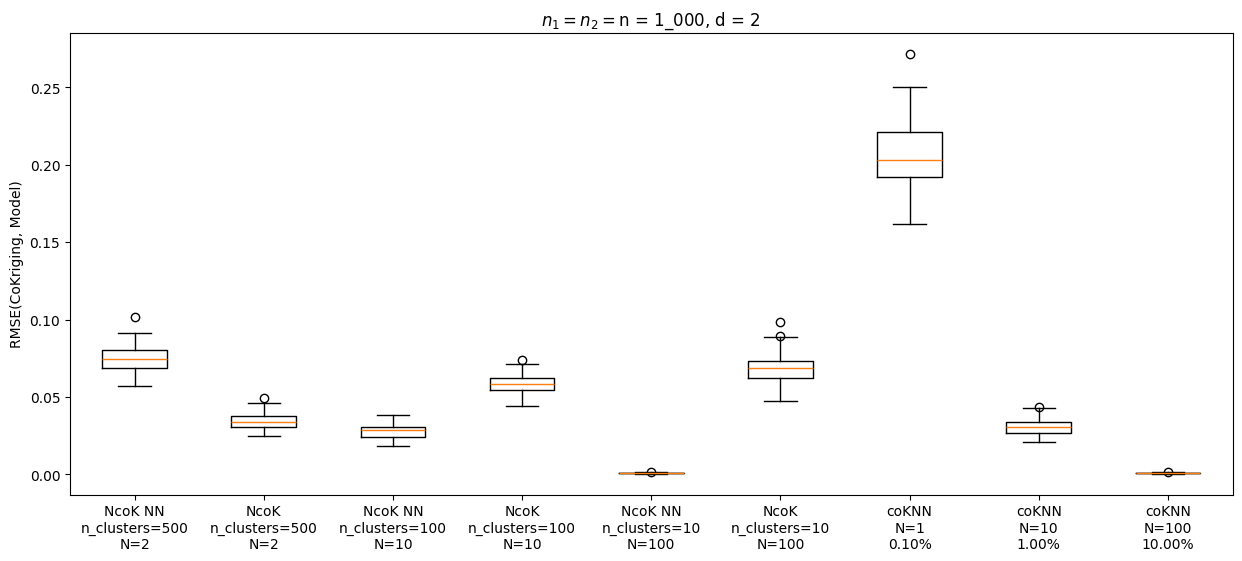

In [23]:
plt.figure(figsize=(15,6))

plt.boxplot(np.hstack([rmses_NcoK, rmses_coKNN]))

plt.xticks(range(1, 1 + 2*len(ns_clusters) + len(Ns)),
           np.array([(f'NcoK NN\n{n_clusters=}\nN={n//n_clusters}', f'NcoK\n{n_clusters=}\nN={n//n_clusters}') for n_clusters in ns_clusters]).flatten().tolist()
           + [f'coKNN\n{N=}\n{N/n:.2%}' for N in Ns])
plt.ylabel('RMSE(CoKriging, Model)')
plt.title(f'$n_1 = n_2 = ${n = :_.0f}, {d = }');

In [33]:
np.hstack([rmses_NcoK_test, rmses_coKNN_test])

array([[0.27754823, 0.27450988, 0.27827374, 0.28370778, 0.27530775,
        0.27728144, 0.32309642, 0.28171674, 0.27524237],
       [0.26043898, 0.24455511, 0.25043788, 0.25659186, 0.25314405,
        0.25548872, 0.30267869, 0.2505482 , 0.25310688],
       [0.29430284, 0.25997738, 0.26359321, 0.27399671, 0.26139369,
        0.28317824, 0.30781485, 0.26621029, 0.2614344 ],
       [0.28285405, 0.26902421, 0.26589387, 0.28396529, 0.26532681,
        0.28382911, 0.35588475, 0.26385915, 0.26531759],
       [0.28974096, 0.27548631, 0.26669001, 0.28080747, 0.27060089,
        0.28929149, 0.34284008, 0.26760698, 0.27060613],
       [0.25030267, 0.2334627 , 0.23485918, 0.2451577 , 0.23090639,
        0.23997656, 0.32995207, 0.23466658, 0.23087826],
       [0.25246481, 0.24168726, 0.2377153 , 0.23914154, 0.23567971,
        0.25231107, 0.3156201 , 0.23688497, 0.23565511],
       [0.26209206, 0.26614988, 0.26894559, 0.27077212, 0.26715616,
        0.27459312, 0.37238588, 0.26990898, 0.26716684],


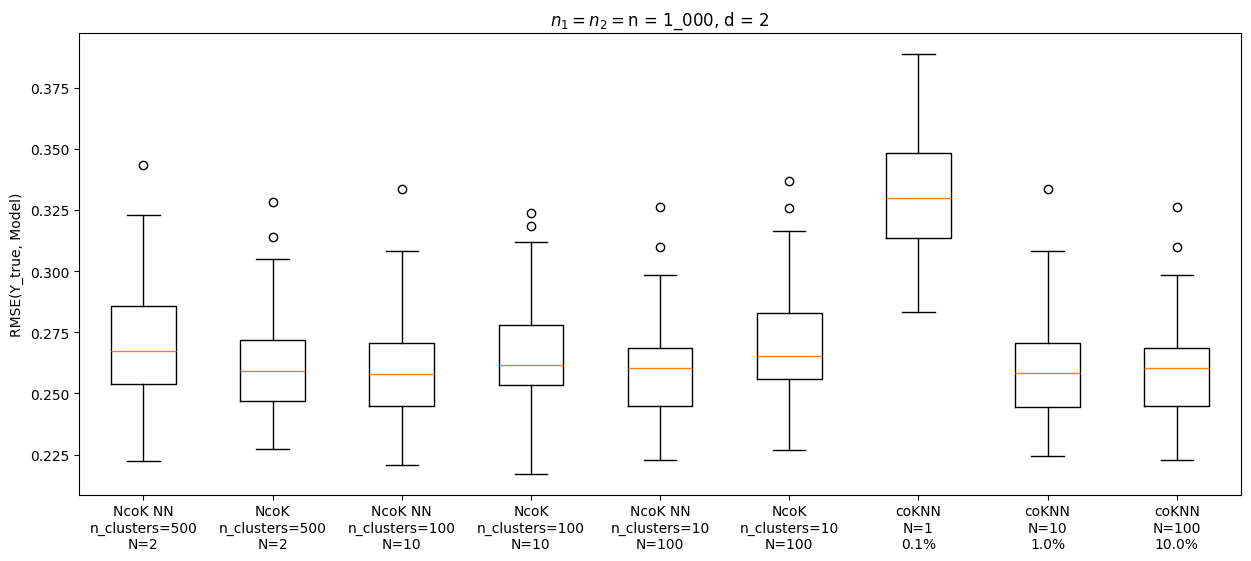

In [24]:
plt.figure(figsize=(15,6))

plt.boxplot(np.hstack([rmses_NcoK_test, rmses_coKNN_test]))

plt.xticks(range(1, 1 + 2*len(ns_clusters) + len(Ns)),
           np.array([(f'NcoK NN\n{n_clusters=}\nN={n//n_clusters}', f'NcoK\n{n_clusters=}\nN={n//n_clusters}') for n_clusters in ns_clusters]).flatten().tolist()
           + [f'coKNN\n{N=}\n{N/n:.1%}' for N in Ns])
plt.ylabel('RMSE(Y_true, Model)')
plt.title(f'$n_1 = n_2 = ${n = :_.0f}, {d = }');

In [34]:
np.hstack([times_NcoK, times_coKNN])

array([[1.56343608e+03, 3.07996671e+01, 1.01338595e+02, 4.72728372e+00,
        2.92656598e+01, 4.69282031e+00, 5.13150692e-02, 7.94534683e-02,
        1.64672112e+00],
       [1.55404389e+03, 2.07668884e+01, 6.63916147e+01, 2.91179442e+00,
        9.48710322e+00, 3.80767417e+00, 2.83935070e-02, 5.43658733e-02,
        8.49957705e-01],
       [1.42789439e+03, 1.94780867e+01, 6.67567945e+01, 2.86047292e+00,
        9.40515471e+00, 3.79965234e+00, 2.38254070e-02, 5.00054359e-02,
        4.26102877e-01],
       [1.45360562e+03, 1.95169621e+01, 6.68503354e+01, 2.96655226e+00,
        9.63231516e+00, 3.86812878e+00, 1.50954723e-02, 6.13572598e-02,
        4.54049110e-01],
       [1.44122198e+03, 1.97332511e+01, 6.67504418e+01, 2.89988422e+00,
        9.47067094e+00, 3.71649504e+00, 1.96158886e-02, 4.49502468e-02,
        4.18549061e-01],
       [1.46203542e+03, 1.95689864e+01, 6.70902662e+01, 2.94996190e+00,
        9.70025730e+00, 3.85996294e+00, 3.84805202e-02, 4.46670055e-02,
        4.6

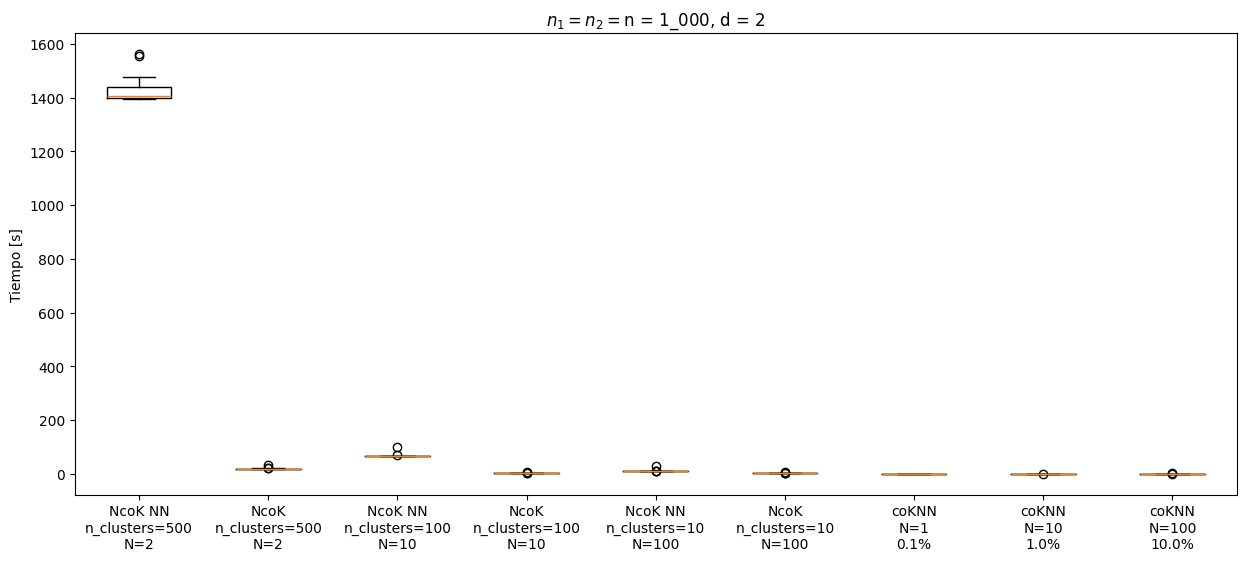

In [25]:
plt.figure(figsize=(15,6))

plt.boxplot(np.hstack([times_NcoK, times_coKNN]))

plt.xticks(range(1, 1 + 2*len(ns_clusters) + len(Ns)),           
           np.array([(f'NcoK NN\n{n_clusters=}\nN={n//n_clusters}', f'NcoK\n{n_clusters=}\nN={n//n_clusters}') for n_clusters in ns_clusters]).flatten().tolist()
           + [f'coKNN\n{N=}\n{N/n:.1%}' for N in Ns])
plt.ylabel('Tiempo [s]')
plt.title(f'$n_1 = n_2 = ${n = :_.0f}, {d = }');

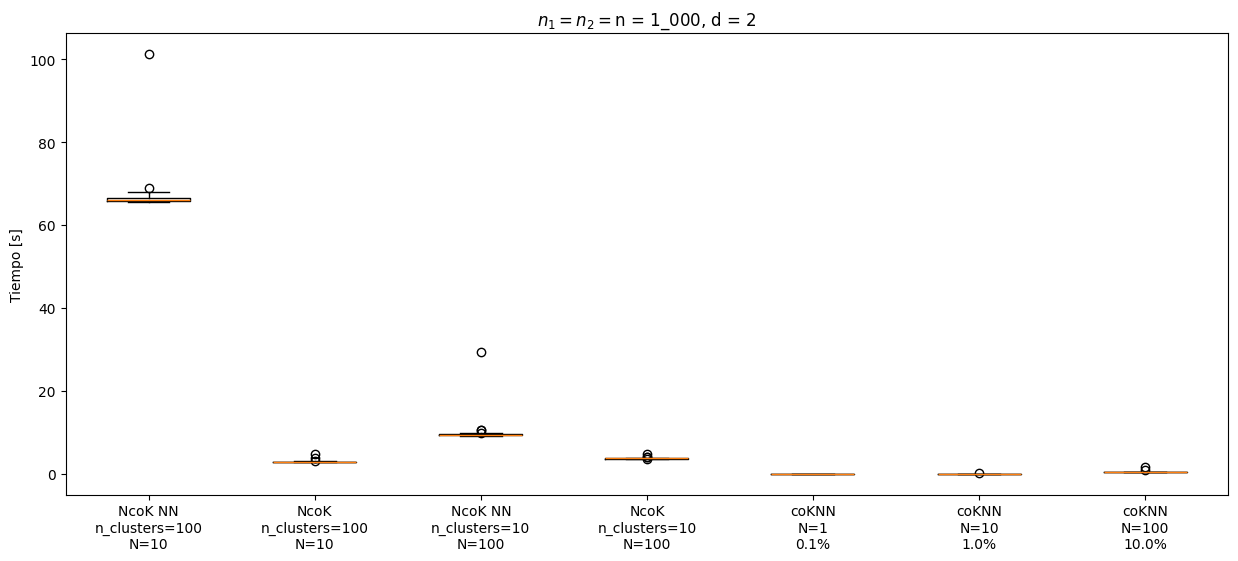

In [29]:
plt.figure(figsize=(15,6))

plt.boxplot(np.hstack([times_NcoK[:, 2:], times_coKNN]))

plt.xticks(range(1, 1 + 2*len(ns_clusters[1:]) + len(Ns)),           
           np.array([(f'NcoK NN\n{n_clusters=}\nN={n//n_clusters}', f'NcoK\n{n_clusters=}\nN={n//n_clusters}') for n_clusters in ns_clusters[1:]]).flatten().tolist()
           + [f'coKNN\n{N=}\n{N/n:.1%}' for N in Ns])
plt.ylabel('Tiempo [s]')
plt.title(f'$n_1 = n_2 = ${n = :_.0f}, {d = }');

# BOX PLOTS 

d = 2, nu = 1/2

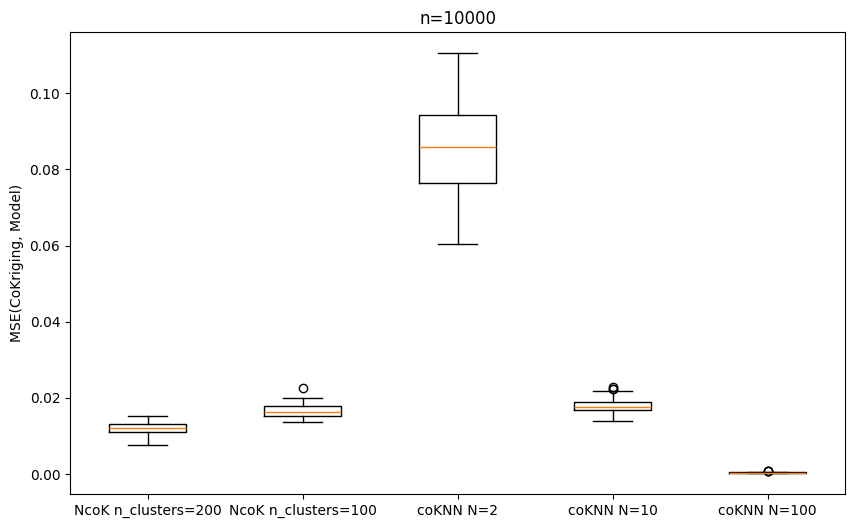

d = 2, nu = 5/2

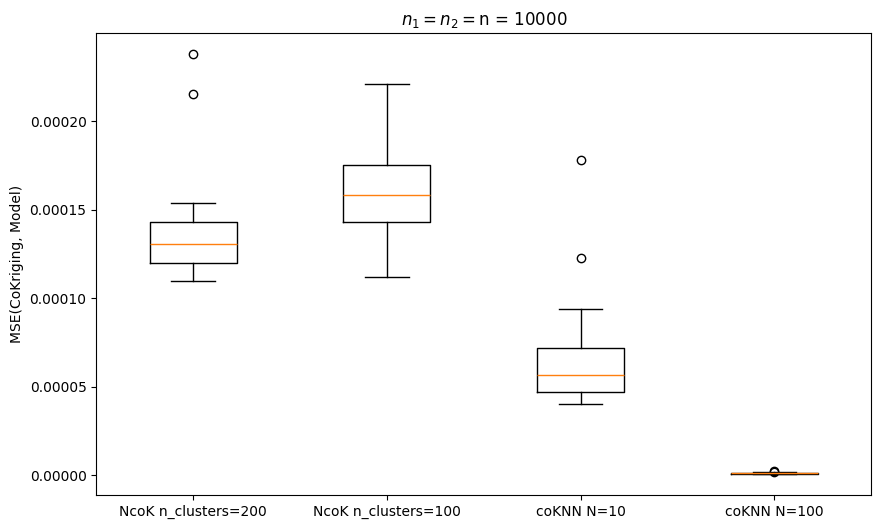